---
---
# **1. Setup**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#@title **1.1.Install packages and dependencies**
#@markdown Thanks to **`mamba`**, the installation takes **less than 5 mins**. \ 
#@markdown It will **restart** the kernel (session).

# %%capture
import contextlib
import timeit
import torch

# -- Start install --
start = timeit.default_timer()

with open("/content/installation.log", "w") as i:
    with contextlib.redirect_stdout(i):
        !wget -c https://repo.anaconda.com/miniconda/Miniconda3-py37_4.12.0-Linux-x86_64.sh
        !chmod +x Miniconda3-py37_4.12.0-Linux-x86_64.sh
        !bash ./Miniconda3-py37_4.12.0-Linux-x86_64.sh -b -f -p /usr/local
        import sys
        sys.path.append('/usr/local/lib/python3.7/site-packages/') 
        !conda install -c conda-forge mamba -y

        #pip
        !pip install py3Dmol==2.0.0.post2
        !pip install pybel==0.15.5
        !pip install rdkit-pypi==2022.3.5
        !pip install pdb2pqr
        !pip install git+https://github.com/Valdes-Tresanco-MS/AutoDockTools_py3
        import os
        os.chdir('/content')
        !git clone https://github.com/tieulongphan8995/dock_util.git
       

       
        
      

        #smina
        !wget https://downloads.sourceforge.net/project/smina/smina.static
        !chmod u+x smina.static
        !./smina.static --help

        

        
        # install conda
        os.chdir('/content')
        !mamba install -c conda-forge -c bioconda mgltools=1.5.7 biopython=1.78 \
          openbabel=3.1.0 plip=2.2.2 zlib=1.2.11 xlsxwriter=3.0.3 -y
       
        !rm -r /content/sample_data /content/condacolab_install.log

stop = timeit.default_timer()
# -- End install --

time_elp = stop - start

print(f"+ Operation completed")
print(f"+ Time elapsed: {int(time_elp//60):02}m {int(time_elp%60):02}s")


+ Operation completed
+ Time elapsed: 03m 20s


In [4]:
#@title **1.2. Import Python modules**

import os
import sys
from rdkit import Chem
from rdkit.Chem import rdFMCS,AllChem, Draw, PandasTools
sys.path.append('/content/dock_util')
from rmsd_cal import *
from result_process import *



import ast
import math
import plip
import timeit
import shutil
import py3Dmol
import contextlib
import xlsxwriter
import urllib.request

import numpy as np
import pandas as pd

from google.colab import drive, files
from tqdm.notebook import tqdm
from openbabel import pybel
from Bio.PDB import PDBIO, PDBParser
from rdkit import Chem
from rdkit.Chem import rdFMCS, AllChem, PandasTools
from plip.exchange.report import BindingSiteReport
from plip.structure.preparation import PDBComplex
os.chdir('/content')
%alias smina /content/smina.static

print(f"+ Imported done")
print(f"+ Environment ready for molecular docking")





+ Imported done
+ Environment ready for molecular docking


In [5]:
%smina --help_advanced

Command line parse error: unrecognised option '--help_advanced'

Correct usage:

Input:
  -r [ --receptor ] arg         rigid part of the receptor (PDBQT)
  --flex arg                    flexible side chains, if any (PDBQT)
  -l [ --ligand ] arg           ligand(s)
  --flexres arg                 flexible side chains specified by comma 
                                separated list of chain:resid or 
                                chain:resid:icode
  --flexdist_ligand arg         Ligand to use for flexdist
  --flexdist arg                set all side chains within specified distance 
                                to flexdist_ligand to flexible

Search space (required):
  --center_x arg                X coordinate of the center
  --center_y arg                Y coordinate of the center
  --center_z arg                Z coordinate of the center
  --size_x arg                  size in the X dimension (Angstroms)
  --size_y arg                  size in the Y dimension (Angstroms)
  --s

# **2. Advanced docking**

In [18]:
#@title **2.1. Perform Docking**
#@markdown Select **< Exhaustiveness >** for molecular docking. (Default: 8)\
#@markdown Autodock Vina will performs molecular docking on targeted protein.\
#@markdown This generate **`ligand_output.pdbqt`**. 

#@markdown **NOTE:** Compound with many rotatable bonds may required higher 
#@markdown level of exhaustiveness to ensure accurate and consistent pose 
#@markdown prediction.


WORK_DIR = "/content/drive/MyDrive/Docking/3ERT/" #@param {type:"string"}
os.chdir(WORK_DIR)
LIG_ID = "oht" #@param {type:"string"}
DCK_FLD = 'DOCKING'
PROT_ID = '3ERT_prot_fix_A'#@param {type:"string"}
REF_ID = 'OHT_A' #@param {type:"string"}


PROT_pdbqt_Dfile =os.path.join(DCK_FLD, f"{PROT_ID}.pdbqt")
LIG_pdbqt_Dfile = os.path.join(DCK_FLD, f"{LIG_ID}/{LIG_ID}.pdbqt")
CONF_Dfile =os.path.join(DCK_FLD, f"config_file")
PROT_pdb_Dfile =os.path.join(DCK_FLD, f"{PROT_ID}.pdb")
REF_pdb_Dfile =os.path.join(DCK_FLD, f"{REF_ID}.pdb")


Select_Docking_type = "Blind docking" #@param ["Basic docking","Blind docking", "Flexible docking with flexdist", "Flexible docking with flexres", "Custom SF"]


Exhaustiveness = 32 #@param {type:"slider", min:1, max:128, step:1}
ex = Exhaustiveness

Number_of_conformations = 100 #@param {type:"slider", min:10, max:1000, step:1}
mode = Number_of_conformations

number_of_cpu = -1 #@param {type:"slider", min:-1, max:32, step:1}
n_cpu = number_of_cpu

#@markdown **1. Blind dock docking**:
#@markdown - Change config file to cover whole protein.
#@markdown - Use autobox_ligand arg for whole protein.

#@markdown **2. Flexible docking**:
#@markdown -  Use **flexdist** arg to set all side chains within specified distance to **flexdist_ligand** to flexible
#@markdown -  Use **flexres** arg for flexible side chains specified by comma separated list of chain:resid

FLEXDIST = 1 #@param {type:"slider", min:1, max:10, step:1} : 
flexdist = Number_of_conformations

Flexres = 'A:52,A:103' #@param {type:"string"}
flexres = Flexres

#@markdown **3. Customer scoring function**:
#@markdown -  Input the custom scoring function file
#@markdown -  Check 2.4 to custom your SF



LIG_out_pdbqt = LIG_ID + "_output.pdbqt"
LIG_out_sdf = LIG_ID + "_output.sdf"
LIG_log_txt = LIG_ID + "_log.txt"
LIG_out_pdbqt_Dfile = os.path.join(DCK_FLD, f"{LIG_ID}/{LIG_out_pdbqt}")
LIG_out_sdf_Dfile = os.path.join(DCK_FLD, f"{LIG_ID}/{LIG_out_sdf}")
LIG_log_txt_Dfile = os.path.join(DCK_FLD, f"{LIG_ID}/{LIG_log_txt}")

Custom_score = 'custom' #@param {type:"string"}
Custom_Dfile =os.path.join(DCK_FLD, Custom_score)

# -- Start docking --
start = timeit.default_timer()
with open(LIG_log_txt_Dfile, "w") as i:

  if Select_Docking_type == "Basic docking":
    %smina --receptor $PROT_pdbqt_Dfile --ligand $LIG_pdbqt_Dfile \
    --out $LIG_out_sdf_Dfile --config $CONF_Dfile \
    --exhaustiveness $ex --num_modes $mode --seed 42 --cpu $n_cpu 
  elif Select_Docking_type == "Blind docking":
    %smina --receptor $PROT_pdbqt_Dfile --ligand $LIG_pdbqt_Dfile \
    --out $LIG_out_sdf_Dfile --autobox_ligand $PROT_pdbqt_Dfile \
    --exhaustiveness $ex --num_modes $mode --seed 42 --cpu $n_cpu 
  elif Select_Docking_type == "Flexible docking with flexdist":
    %smina --receptor $PROT_pdbqt_Dfile --ligand $LIG_pdbqt_Dfile \
    --out $LIG_out_sdf_Dfile --config $CONF_Dfile \
    --flexdist $flexdist --flexdist_ligand $LIG_pdbqt_Dfile --out_flex flexout.sdf \
    --exhaustiveness $ex --num_modes $mode --seed 42 --cpu $n_cpu 
  elif Select_Docking_type == "Flexible docking with flexres":
    %smina --receptor $PROT_pdbqt_Dfile --ligand $LIG_pdbqt_Dfile \
    --out $LIG_out_sdf_Dfile --config $CONF_Dfile \
    --flexres $flexres --out_flex flexout2.sdf\
    --exhaustiveness $ex --num_modes $mode --seed 42 --cpu $n_cpu 
  elif Select_Docking_type == "Custom SF":
    %smina --receptor $PROT_pdbqt_Dfile --ligand $LIG_pdbqt_Dfile \
    --out $LIG_out_sdf_Dfile --config $CONF_Dfile \
    --score_only --custom_scoring $Custom_Dfile \
    --exhaustiveness $ex --num_modes $mode --seed 42 --cpu $n_cpu
 



    
with open(LIG_log_txt_Dfile, "r") as r:
    data = r.read().splitlines(True)
with open(LIG_log_txt_Dfile, "w") as o:
    o.writelines(data[1:])
stop = timeit.default_timer()
  # -- End docking --

time_elp = stop - start

print(f"+ Operation completed")
print(f"+ Time elapsed: {int(time_elp//60):02}m {int(time_elp%60):02}s")


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 42

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity 

In [19]:
#@title **2.2. Visualization**
import py3Dmol
v = py3Dmol.view()
v.addModel(open(PROT_pdb_Dfile).read())
v.setStyle({'cartoon':{},'stick':{'radius':.1}})
v.addModel(open(REF_pdb_Dfile).read())
v.setStyle({'model':1},{'stick':{'colorscheme':'redCarbon','radius':.125}})
v.addModelsAsFrames(open(LIG_out_sdf_Dfile).read())
v.setStyle({'model':2},{'stick':{'colorscheme':'greenCarbon'}})
v.animate({'interval':1000})
v.zoomTo({'model':1})
v.rotate(90)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## **2.3 RMSD calculation**

,minimizedAffinity,ID,ROMol,RMSD,Software
0,-7.82598257,,,8.437200,Smina
1,-7.76952839,,,8.207190,Smina
2,-7.13546562,,,9.369238,Smina
3,-6.85812378,,,10.876863,Smina
4,-6.62805557,,,11.952172,Smina

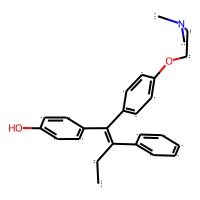
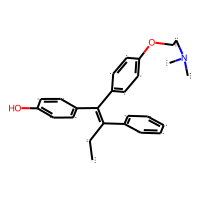
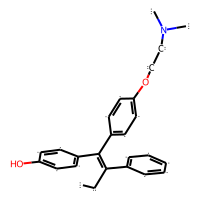
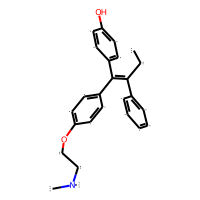
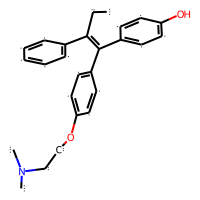

In [ ]:
#@title **2.3.1 RMSD calculation with low exhautiveness**

SminaPoses=PandasTools.LoadSDF(LIG_out_sdf_Dfile)
Reference=Chem.rdmolfiles.MolFromPDBFile(f'EXPERIMENTAL/{REF_ID}.pdb')
SminaPoses['RMSD']=[get_inplace_rmsd(ref=Reference,target=SminaPoses.loc[i,"ROMol"]) for i in SminaPoses.index]
SminaPoses['Software']=["Smina" for i in SminaPoses.index]

SminaPoses.head()

,minimizedAffinity,ID,ROMol,RMSD,Software
0,-9.80914688,,,1.651943,Smina
1,-8.09111023,,,8.185911,Smina
2,-8.05055332,,,8.492925,Smina
3,-7.7541256,,,8.844160,Smina
4,-7.53834581,,,9.342351,Smina

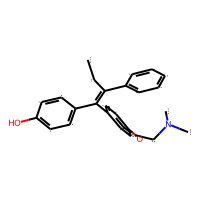
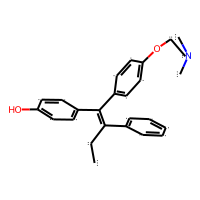
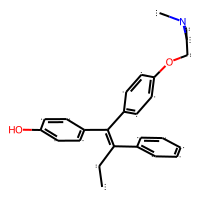
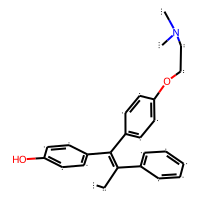
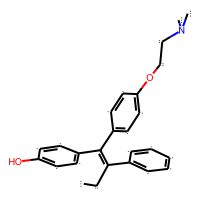

In [20]:
#@title **2.3.2 RMSD calculation with high exhautiveness**

SminaPoses=PandasTools.LoadSDF(LIG_out_sdf_Dfile)
Reference=Chem.rdmolfiles.MolFromPDBFile(f'EXPERIMENTAL/{REF_ID}.pdb')
SminaPoses['RMSD']=[get_inplace_rmsd(ref=Reference,target=SminaPoses.loc[i,"ROMol"]) for i in SminaPoses.index]
SminaPoses['Software']=["Smina" for i in SminaPoses.index]

SminaPoses.head()

## 2.4. Custom scoring fucntion

In [ ]:
open('DOCKING/custom','wt').write('''
1.0  ad4_solvation(d-sigma=3.6,_s/q=0.01097,_c=8)  desolvation, s/q is charge dependence
1.0  ad4_solvation(d-sigma=3.6,_s/q=0.0,_c=8)  
1.0  electrostatic(i=1,_^=100,_c=8)	i is the exponent of the distance, see everything.h for details
1.0  electrostatic(i=2,_^=100,_c=8)
1.0  gauss(o=0,_w=0.5,_c=8)		o is offset, w is width of gaussian
1.0  gauss(o=3,_w=2,_c=8)
1.0  repulsion(o=0,_c=8)	o is offset of squared distance repulsion
1.0  hydrophobic(g=0.5,_b=1.5,_c=8)		g is a good distance, b the bad distance
1.0  non_hydrophobic(g=0.5,_b=1.5,_c=8)	value is linearly interpolated between g and b
1.0  vdw(i=4,_j=8,_s=0,_^=100,_c=8)	i and j are LJ exponents
1.0  vdw(i=6,_j=12,_s=1,_^=100,_c=8) s is the smoothing, ^ is the cap
1.0  non_dir_h_bond(g=-0.7,_b=0,_c=8)	good and bad
1.0  non_dir_anti_h_bond_quadratic(o=0.4,_c=8) like repulsion, but for hbond, don't use	
1.0  non_dir_h_bond_lj(o=-0.7,_^=100,_c=8)	LJ 10-12 potential, capped at ^
1.0 acceptor_acceptor_quadratic(o=0,_c=8)	quadratic potential between hydrogen bond acceptors
1.0 donor_donor_quadratic(o=0,_c=8)	quadratic potential between hydroben bond donors
1.0  num_tors_div	div constant terms are not linearly independent
1.0  num_heavy_atoms_div	
1.0  num_heavy_atoms	these terms are just added
1.0  num_tors_add
1.0  num_tors_sqr
1.0  num_tors_sqrt
1.0  num_hydrophobic_atoms
1.0  ligand_length
''');